# Islamophhobia Detection with BERT using Keras and TensorFlow 2

In [2]:
!nvidia-smi

Tue Sep 15 02:22:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install tensorflow-gpu 

     |████████████████████████████████| 320.4MB 49kB/s 


In [4]:
!pip install --upgrade grpcio

Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.32.0)


In [5]:
!pip install tqdm

In [6]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 3.5MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-cp36-none-any.whl size=30318 sha256=863a26ffe041bcda9ea5da749133e256e50d96781e7c1fc7bbb27955b5492923
  Stored in directory: /root/.cache/pip/wheels/07/a0/b4/75b0601ebaa41e517a797fe9cea119c789664c8408f8a74ae9
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=9dd4e03b036d7603e775534a6fb7c4d24208bbe31e5d81003bd2f16fba31be47
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=affb0798de08a3bfecbc4adf44f1214162463d4ca65f2d3232c67686ad6d5520
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [7]:
!pip install googletrans

     |████████████████████████████████| 61kB 4.2MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 962kB 14.0MB/s 
     |████████████████████████████████| 61kB 10.4MB/s 
     |████████████████████████████████| 71kB 11.8MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=2d57653030105a610d74c8fb42134257903f17c4009d99b679e632f5b68b704b
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=d1765f4e2775425c7ad0ec2d1d0a6e82c77b985a0f3d14befa651a830e016384
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [8]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 5.5MB/s 


In [9]:
!pip install googletrans

In [10]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

import re

# translator
import googletrans
from googletrans import Translator

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data


In [11]:
# Hindi translated data
!gdown --id 1zJVv_Ldh5vhDmw2mJSrgMcKlLt1fWyBw --output data-task1.csv

# Hindi data
!gdown --id 1EQRLvSUJn6VxFluTqNEGxXcV8_5OmCaW --output data-task3.csv

Downloading...
From: https://drive.google.com/uc?id=1zJVv_Ldh5vhDmw2mJSrgMcKlLt1fWyBw
To: /content/data-task1.csv
100% 797k/797k [00:00<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EQRLvSUJn6VxFluTqNEGxXcV8_5OmCaW
To: /content/data-task3.csv
100% 1.63M/1.63M [00:00<00:00, 108MB/s]


In [12]:
orig_df = pd.read_csv('data-task3.csv', 
                   delimiter=',')
orig_df.columns = ['Text', 'Label']
orig_df.head(15)
orig_df["Text"] = orig_df["Text"].astype(str)
orig_df["Label"] = orig_df["Label"].astype(str)

In [13]:
orig_df.Text[3]

"'अमीन के 500 से अधिक छात्रों ने सर्वे भवन के गेट पर आधा नंगा होकर किया प्रदर्शन  पप्पू यादव ने बुलंद की\\xa0आवाज"

In [14]:
df = pd.read_csv('data-task1.csv', 
                   delimiter=',')
df.columns = ['Text', 'Label']
df.head(15)
df["Text"] = df["Text"].astype(str)
df["Label"] = df["Label"].astype(str)

In [15]:
df.Text[3]

"'More than 500 students of Amin performed half-naked at the gate of the survey building. Pappu Yadav raised his voice"

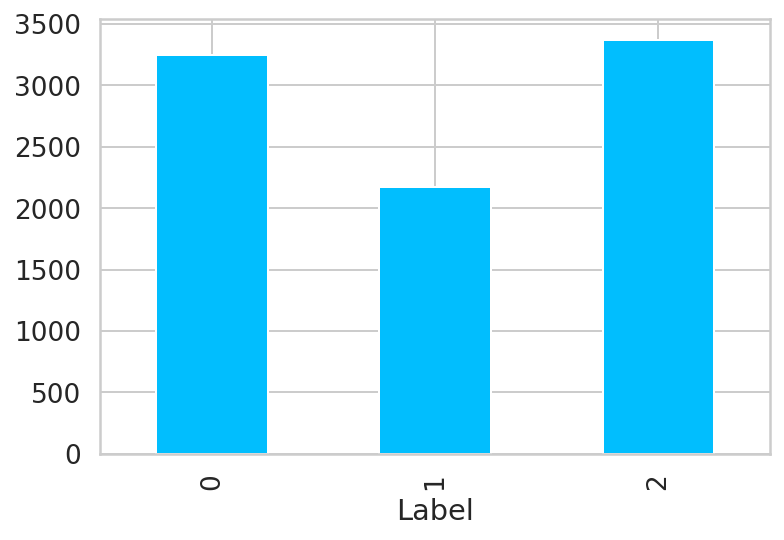

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [17]:

# For entire dataset sentences for each labels 
df.Label.value_counts()

2    3373
0    3245
1    2172
Name: Label, dtype: int64

In [18]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [19]:
new_text, new_label = balanceClasses(df['Text'], df['Label'])

In [20]:
data_df = pd.DataFrame(new_text)
data_df.columns = ['Text']
data_df['Label'] = new_label
data_df = pd.concat([df, data_df])

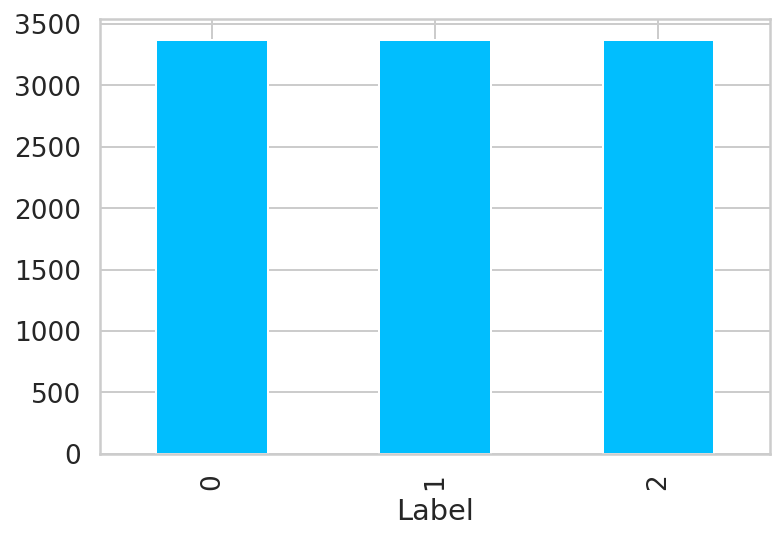

In [21]:
fig1 = plt.figure(figsize=(6,4))
data_df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [22]:
df = data_df

In [23]:
df.Label.value_counts()

2    3373
0    3372
1    3372
Name: Label, dtype: int64

In [24]:
df=df.sample(frac=1).reset_index(drop=True)
df

,Text,Label
0,"'To all those who have saluted,' Alaqum Aslam ...",1
1,'@Jalajisay for the last Congress is Lallu ji ...,0
2,"'Happy Birthday to the Respected Mother, Mars....",0
3,"Happy Islamic New Year, your approved bag Sarv...",1
4,'@ Pablo_neharu_da @ sunita_yadava 122 uare a ...,2
...,...,...
10112,'@ imMAK02 @ pbhushan1 you will also have to a...,2
10113,"'What is Jihadist, Radical and Radical Terror?...",2
10114,"'Which country has that Surat e Ilahi settled,...",1
10115,'@mysandeepmishra NRC is required. Find the ji...,2


Data Preprocessing

In [25]:
def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceFourColon(x))

In [26]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r" \n ", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

df['Text'] = df['Text'].apply(lambda x: textPattern(x))

In [27]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.10, random_state=42)

In [28]:
df.head()

,Text,Label
0,To all those who have saluted Alaqum Aslam an...,1
1,Jalajisay for the last Congress is Lallu ji Z...,0
2,Happy Birthday to the Respected Mother Mars M...,0
3,Happy Islamic New Year your approved bag Sarva...,1
4,Pablo neharu da sunita yadava 122 uare a jehr...,2


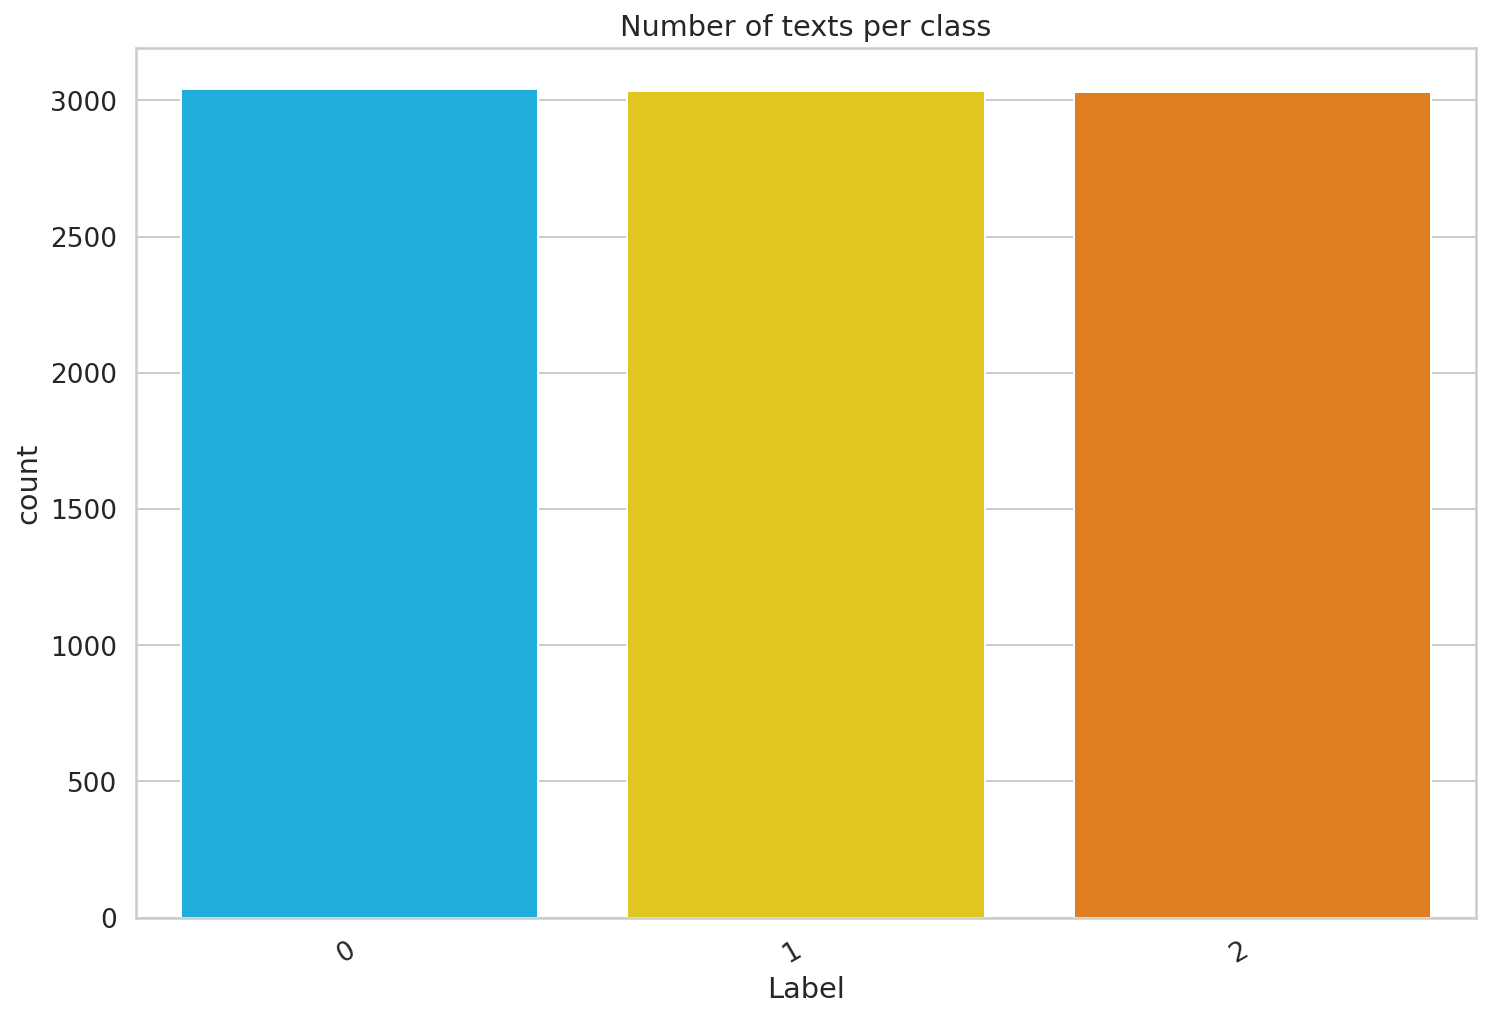

In [29]:
chart = sns.countplot(train.Label, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per class")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

# Islamophhobia Detection with BERT


In [30]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-09-15 02:23:34--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   167MB/s    in 2.3s    

2020-09-15 02:23:36 (167 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [31]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [32]:
os.makedirs("model", exist_ok=True)

In [33]:
!mv uncased_L-12_H-768_A-12/ model

In [34]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [35]:
class IslamophobiaDetectionData:
  DATA_COLUMN = "Text"
  LABEL_COLUMN = "Label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IslamophobiaDetectionData.DATA_COLUMN], row[IslamophobiaDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [36]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [37]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  #print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)

  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)


  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
  
  model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)
        
  return model

## Training

In [43]:
classes = train.Label.unique().tolist()

data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)

9105it [00:03, 2761.66it/s]
1012it [00:00, 2832.83it/s]


max seq_len 120


In [44]:
model = create_model(data.max_seq_len, bert_ckpt_file)

Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f1cea4d7b38> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [45]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 120)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 120, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [47]:


history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5
)

Epoch 1/5
513/513 [==============================] - 312s 609ms/step - loss: 0.7048 - acc: 0.8429 - val_loss: 0.6118 - val_acc: 0.9396
Epoch 2/5
513/513 [==============================] - 311s 607ms/step - loss: 0.6186 - acc: 0.9323 - val_loss: 0.6143 - val_acc: 0.9319
Epoch 3/5
513/513 [==============================] - 310s 603ms/step - loss: 0.6015 - acc: 0.9489 - val_loss: 0.6007 - val_acc: 0.9517
Epoch 4/5
513/513 [==============================] - 309s 603ms/step - loss: 0.5924 - acc: 0.9583 - val_loss: 0.6046 - val_acc: 0.9484
Epoch 5/5
513/513 [==============================] - 310s 604ms/step - loss: 0.5873 - acc: 0.9640 - val_loss: 0.6149 - val_acc: 0.9363


## Evaluation

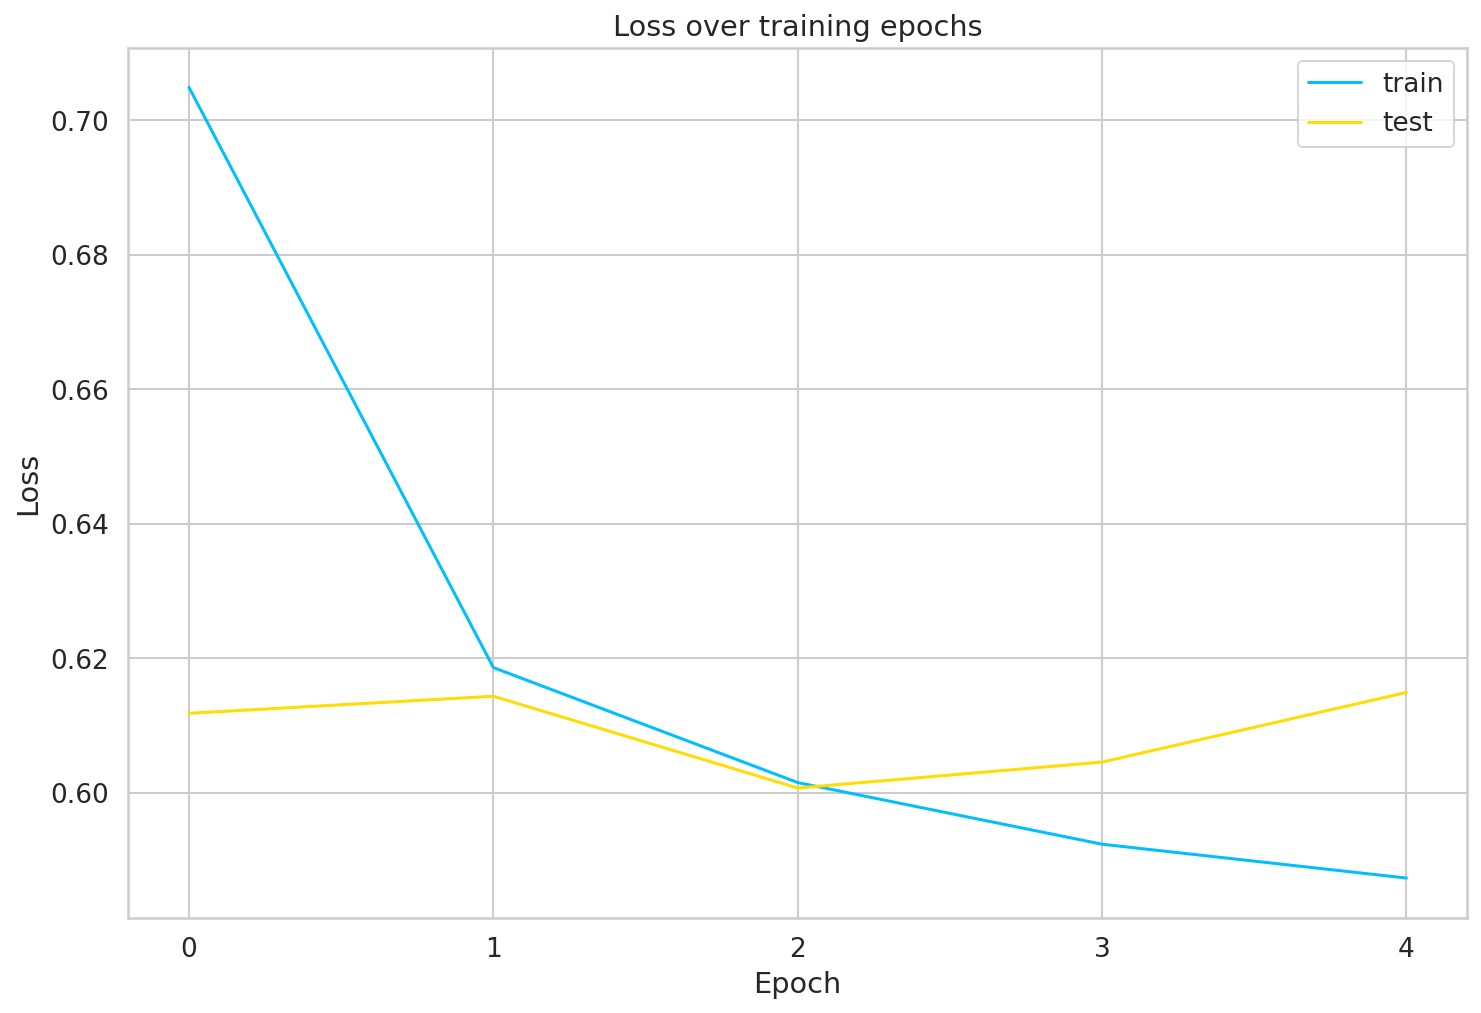

In [48]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

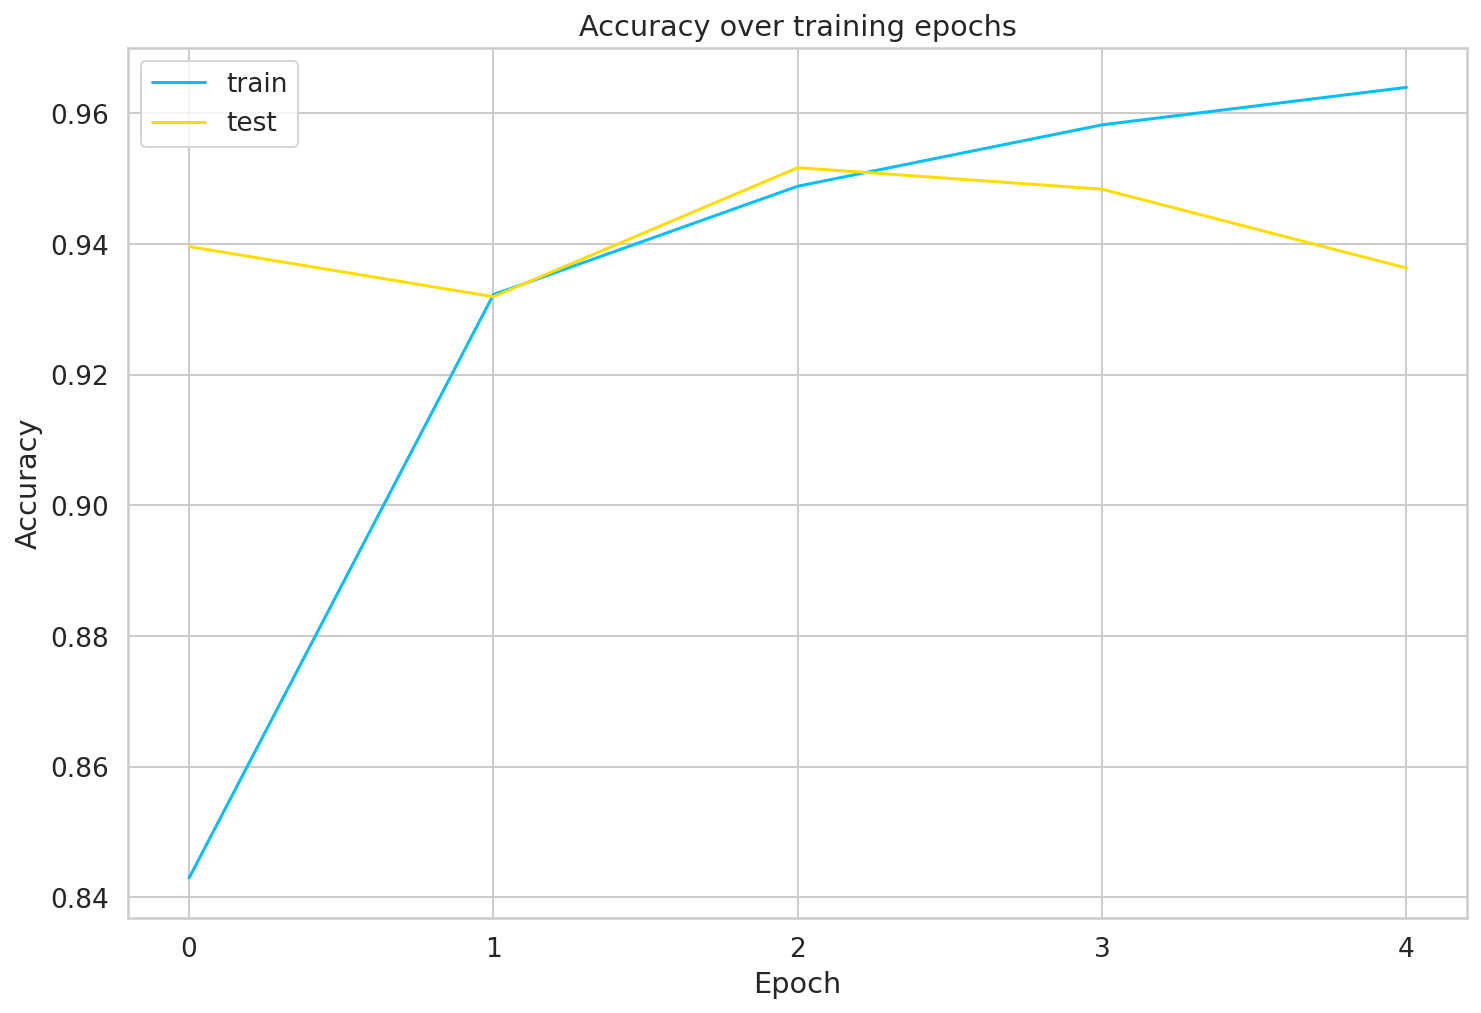

In [49]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [50]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

32/32 [==============================] - 9s 271ms/step - loss: 0.6122 - acc: 0.9377
train acc 0.9654036164283752
test acc 0.937747061252594


In [51]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [52]:
print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       337
           1       0.97      0.88      0.92       332
           2       0.93      0.96      0.94       343

    accuracy                           0.94      1012
   macro avg       0.94      0.94      0.94      1012
weighted avg       0.94      0.94      0.94      1012



In [53]:

cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

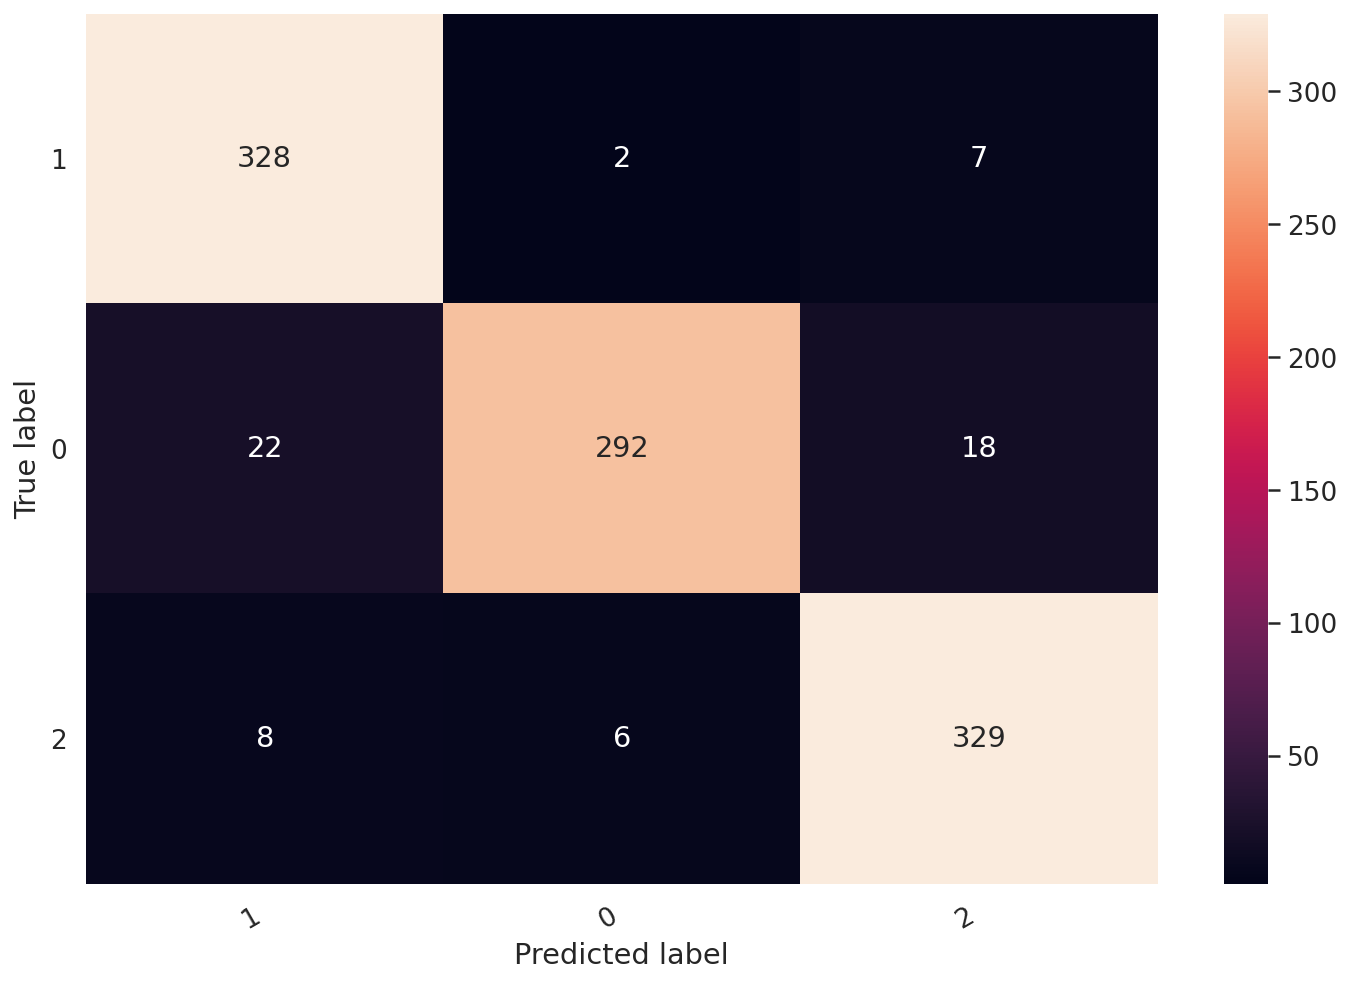

In [54]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# 10 Fold cross validation

In [55]:
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

kFold = 10

#To get accuracy of the model for 10 different splits
scores = []
training_accuracy = []
testing_accuracy = []
print("BERT: ")
for i in range(kFold):
    print('Fold ', i+1)
    print('')
    # Splitting data into test and train
    train, test = train_test_split(df, test_size=0.10, shuffle = True)

    classes = train.Label.unique().tolist()
    data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)
    model = create_model(data.max_seq_len, bert_ckpt_file)
    history = model.fit( x=data.train_x, y=data.train_y,validation_split=0.1,batch_size=16, shuffle=True,epochs=5)
    #train_loss, train_acc = model.evaluate(data.train_x, data.train_y)
    test_loss, test_acc = model.evaluate(data.test_x, data.test_y)
    
    #training_accuracy.append(train_acc)
    testing_accuracy.append(test_acc)

    y_pred = model.predict(data.test_x).argmax(axis=-1)

    scoreValue =accuracy_score(data.test_y, y_pred)
    scores.append(scoreValue)


296it [00:00, 2954.34it/s]

BERT: 
Fold  1



9105it [00:03, 2815.70it/s]
1012it [00:00, 2811.58it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f1c7c05cfd0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 319s 623ms/step - loss: 0.7675 - acc: 0.7645 - val_loss: 0.6349 - val_acc: 0.9155
Epoch 2/5
513/513 [==============================] - 317s 617ms/step - loss: 0.6184 - acc: 0.9321 - val_loss: 0.6173 - val_acc: 0.9319
Epoch 3/5
513/513 [==============================] - 317s 617ms/step - loss

284it [00:00, 2838.32it/s]

Fold  2



9105it [00:03, 2785.88it/s]
1012it [00:00, 2827.91it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f1b2653bba8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 317s 618ms/step - loss: 0.7444 - acc: 0.7988 - val_loss: 0.6292 - val_acc: 0.9232
Epoch 2/5
513/513 [==============================] - 314s 612ms/step - loss: 0.6133 - acc: 0.9384 - val_loss: 0.6098 - val_acc: 0.9396
Epoch 3/5
513/513 [==============================] - 313s 611ms/step - loss

271it [00:00, 2708.38it/s]

Fold  3



9105it [00:03, 2741.98it/s]
1012it [00:00, 2815.00it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f1b26bd5128> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 319s 621ms/step - loss: 0.7058 - acc: 0.8407 - val_loss: 0.6414 - val_acc: 0.9100
Epoch 2/5
513/513 [==============================] - 315s 614ms/step - loss: 0.6159 - acc: 0.9339 - val_loss: 0.6327 - val_acc: 0.9188
Epoch 3/5
513/513 [==============================] - 313s 611ms/step - loss

279it [00:00, 2783.64it/s]

Fold  4



9105it [00:03, 2762.37it/s]
1012it [00:00, 2768.51it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f1b2945a5c0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 316s 616ms/step - loss: 0.7377 - acc: 0.8042 - val_loss: 0.6217 - val_acc: 0.9276
Epoch 2/5
513/513 [==============================] - 313s 611ms/step - loss: 0.6132 - acc: 0.9380 - val_loss: 0.6104 - val_acc: 0.9418
Epoch 3/5
513/513 [==============================] - 314s 612ms/step - loss

283it [00:00, 2829.94it/s]

Fold  5



9105it [00:03, 2775.35it/s]
1012it [00:00, 2683.49it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f1a244e0dd8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 320s 624ms/step - loss: 0.7077 - acc: 0.8413 - val_loss: 0.6284 - val_acc: 0.9199
Epoch 2/5
513/513 [==============================] - 318s 620ms/step - loss: 0.6165 - acc: 0.9329 - val_loss: 0.6203 - val_acc: 0.9297
Epoch 3/5
513/513 [==============================] - 318s 620ms/step - loss

258it [00:00, 2576.07it/s]

Fold  6



9105it [00:03, 2762.63it/s]
1012it [00:00, 2604.91it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f1c8732f898> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 320s 623ms/step - loss: 0.7084 - acc: 0.8395 - val_loss: 0.6221 - val_acc: 0.9265
Epoch 2/5
513/513 [==============================] - 317s 618ms/step - loss: 0.6139 - acc: 0.9361 - val_loss: 0.6052 - val_acc: 0.9462
Epoch 3/5
513/513 [==============================] - 317s 617ms/step - loss

277it [00:00, 2765.01it/s]

Fold  7



9105it [00:03, 2748.41it/s]
1012it [00:00, 2740.88it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f1a24706d68> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 316s 616ms/step - loss: 0.7406 - acc: 0.8007 - val_loss: 0.6490 - val_acc: 0.8968
Epoch 2/5
513/513 [==============================] - 314s 611ms/step - loss: 0.6166 - acc: 0.9348 - val_loss: 0.6144 - val_acc: 0.9352
Epoch 3/5
513/513 [==============================] - 314s 611ms/step - loss

275it [00:00, 2748.74it/s]

Fold  8



9105it [00:03, 2774.34it/s]
1012it [00:00, 2831.86it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f1a246ff2e8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 317s 617ms/step - loss: 0.7042 - acc: 0.8448 - val_loss: 0.6349 - val_acc: 0.9144
Epoch 2/5
513/513 [==============================] - 314s 611ms/step - loss: 0.6182 - acc: 0.9318 - val_loss: 0.6299 - val_acc: 0.9199
Epoch 3/5
513/513 [==============================] - 313s 610ms/step - loss

280it [00:00, 2793.85it/s]

Fold  9



9105it [00:03, 2801.47it/s]
1012it [00:00, 2725.88it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f1c866a2f98> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 315s 615ms/step - loss: 0.7195 - acc: 0.8228 - val_loss: 0.6262 - val_acc: 0.9210
Epoch 2/5
513/513 [==============================] - 313s 610ms/step - loss: 0.6147 - acc: 0.9358 - val_loss: 0.6169 - val_acc: 0.9308
Epoch 3/5
513/513 [==============================] - 313s 609ms/step - loss

271it [00:00, 2707.56it/s]

Fold  10



9105it [00:03, 2786.65it/s]
1012it [00:00, 2683.11it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f1a24b04eb8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 315s 615ms/step - loss: 0.7076 - acc: 0.8402 - val_loss: 0.6194 - val_acc: 0.9286
Epoch 2/5
513/513 [==============================] - 312s 609ms/step - loss: 0.6212 - acc: 0.9285 - val_loss: 0.6169 - val_acc: 0.9341
Epoch 3/5
513/513 [==============================] - 313s 610ms/step - loss

In [56]:

print('')
Mean_score = sum(scores) / len(scores)
print(f" Mean predict: {Mean_score}" )

mean_test = sum(testing_accuracy)/len(testing_accuracy)
print(f" Mean testing accuracy for 10 folds: {mean_test}" )


 Mean predict: 0.9466403162055336
 Mean testing accuracy for 10 folds: 0.9466403186321258


In [57]:
translator = Translator()
sentences = []
# 1
hin_text =  "इसलाम सुंदर है"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
sentences.append(trans.text)

# 0
hin_text =  " समाज वादी  पार्टी  जिंदाबाद "
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
sentences.append(trans.text)

# 2
hin_text =  "'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
sentences.append(trans.text)

# 2
sentences.append( "Play our song now you asshole jehadi muslim")

# 0
sentences.append( "Rate this book as awful")


pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nLabel:", classes[label])
  print()

Hindi:  इसलाम सुंदर है
Translated: Islam is beautiful
Hindi:   समाज वादी  पार्टी  जिंदाबाद 
Translated: Samajwadi Party Zindabad
Hindi:  'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂
Translated: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂
text: Islam is beautiful 
Label: 1

text: Samajwadi Party Zindabad 
Label: 0

text: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂 
Label: 0

text: Play our song now you asshole jehadi muslim 
Label: 2

text: Rate this book as awful 
Label: 1



# Reference

1. Movie Reviews with bert-for-tf2 https://colab.research.google.com/drive/1esTDT7S7-31Uiwr8Hj1meV1aokeo8AYX?authuser=1